<a href="https://colab.research.google.com/github/esha345/NeuralStyleTransfer/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import PIL
from tensorflow.keras import Model
import cv2
import matplotlib.pyplot as plt

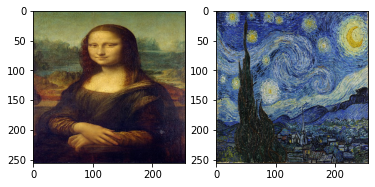

In [ ]:
%matplotlib inline
content_image = cv2.resize(cv2.imread('/content/drive/MyDrive/Colab Notebooks/content4.jpg'), (256, 256))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('/content/drive/MyDrive/Colab Notebooks/style3.jpg'), (256, 256))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#first load the vgg19 model
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#lets print model summary
for layer in vgg19.layers:
  print("Layer name: {0} and Layer shape: {1}".format(layer.name,layer.output_shape))

Layer name: input_1 and Layer shape: [(None, None, None, 3)]
Layer name: block1_conv1 and Layer shape: (None, None, None, 64)
Layer name: block1_conv2 and Layer shape: (None, None, None, 64)
Layer name: block1_pool and Layer shape: (None, None, None, 64)
Layer name: block2_conv1 and Layer shape: (None, None, None, 128)
Layer name: block2_conv2 and Layer shape: (None, None, None, 128)
Layer name: block2_pool and Layer shape: (None, None, None, 128)
Layer name: block3_conv1 and Layer shape: (None, None, None, 256)
Layer name: block3_conv2 and Layer shape: (None, None, None, 256)
Layer name: block3_conv3 and Layer shape: (None, None, None, 256)
Layer name: block3_conv4 and Layer shape: (None, None, None, 256)
Layer name: block3_pool and Layer shape: (None, None, None, 256)
Layer name: block4_conv1 and Layer shape: (None, None, None, 512)
Layer name: block4_conv2 and Layer shape: (None, None, None, 512)
Layer name: block4_conv3 and Layer shape: (None, None, None, 512)
Layer name: block4_co

In [ ]:
#calculating the gram matrix for style loss
def gram_matrix(input_tensor):
  product = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  final_matrix = tf.expand_dims(product,axis=0)
  input_shape = tf.shape(input_tensor)
  ij = tf.cast(input_shape[1]*input_shape[2],tf.float32)
  return final_matrix/ij


In [ ]:
#creating the model
def load_model():
  vgg19 = tf.keras.applications.VGG19(include_top=False,weights='imagenet')
  vgg19.trainable=False
  content_layers = ['block4_conv4']
  content_output = vgg19.get_layer(content_layers[0]).output
  style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
  style_output = [vgg19.get_layer(layer).output for layer in style_layers]
  gram_style_output = [gram_matrix(output) for output in style_output]
  model = Model([vgg19.input],[content_output,gram_style_output]) 
  return model

In [ ]:
#calculating loss
def loss(content_output, style_output, content_target, style_target):
  alpha = 1e-1
  beta = 1e2
  content_loss = tf.reduce_mean((content_output - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output-target)**2) for output,target in zip(style_output,style_target)])
  final_loss = alpha*content_loss + beta*style_loss
  return final_loss

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
vgg19_model = load_model()
content_target = vgg19_model(np.array([content_image*255]))[0]
style_target = vgg19_model(np.array([style_image*255]))[1]

In [ ]:
def train_step(image,epoch):
  with tf.GradientTape() as tape:
    output = vgg19_model(image*255)
    total_loss = loss(output[0],output[1],content_target,style_target)
  gradient = tape.gradient(total_loss,image)
  optimizer.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min = 0.0,clip_value_max=1.0))
  if (epoch%50==0):
    print("Epoch: {0}--> Loss: {1}".format(epoch,total_loss))

In [ ]:
epoch = 500
image = tf.image.convert_image_dtype(content_image,tf.float32)
image = tf.Variable([image])
for i in range(epoch):
  train_step(image,i)

Epoch: 0--> Loss: 19220045758464.0
Epoch: 50--> Loss: 625334878208.0
Epoch: 100--> Loss: 318798921728.0
Epoch: 150--> Loss: 185767608320.0
Epoch: 200--> Loss: 123501420544.0
Epoch: 250--> Loss: 86244818944.0
Epoch: 300--> Loss: 63645265920.0
Epoch: 350--> Loss: 49090592768.0
Epoch: 400--> Loss: 39361318912.0
Epoch: 450--> Loss: 33013946368.0


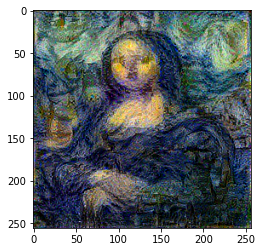

In [ ]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()